# Baseline model

Bertrand Thia (bt2513)

In this notebook, we are going to build a baseline model and explore the possible ways to improve it.

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


# Loading the data

In [2]:
train_labels = pd.read_csv('./train.csv')

In [3]:
train_labels['label'].value_counts()

normal       350
bacterial    350
viral        350
covid         77
Name: label, dtype: int64

In [4]:
train_labels['label'].value_counts(normalize= True)

normal       0.310559
bacterial    0.310559
viral        0.310559
covid        0.068323
Name: label, dtype: float64

As we saw in the previous notebook, our dataset is imbalanced and the number of covid cases is very low (~6% of the data). To address this issue, we will try class weigthing and oversampling later.

# Data preprocessing

### Splitting into training set and validation set 

In [5]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

### Loading the standardized data

Let's load the standardized data that we processed in the previous notebook:

In [6]:
train_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

In [7]:
X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= './train2/',
                                            x_col = 'filename',
                                            y_col = 'label',
                                            target_size= (188, 234), 
                                            batch_size= 32, 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train2/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= 32, 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are going to assess the performances of a CNN with 3 layers to begin:

In [40]:
bas_model = Sequential()
bas_model.add(Conv2D(32, (3, 3), input_shape= (188, 234, 1), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(64, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(128, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Flatten())
bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 32, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 4, activation= 'softmax'))

In [41]:
bas_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 186, 232, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 93, 116, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 91, 114, 64)       18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 57, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 43, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 21, 27, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 72576)            

In [42]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(lr= 0.001), 
                 metrics = ['accuracy'])

* ### Training 

In [45]:
epochs= 50
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 5)
#checkpoint = ModelCheckpoint("best_model.hdf5", monitor= 'val_acc', verbose= 1, save_best_only= True)

In [46]:
bas_model.fit_generator(X_train, 
                        steps_per_epoch= len(train_set) // 32, 
                        epochs= epochs, 
                        verbose= 1, 
                        validation_data = X_val, 
                        validation_steps= len(valid_set) // 32,
                        callbacks= [es])

Epoch 1/50
28/28 [==============================] - 30s 1s/step - loss: 0.8806 - accuracy: 0.5926 - val_loss: 0.9906 - val_accuracy: 0.5848
Epoch 2/50
28/28 [==============================] - 31s 1s/step - loss: 0.8426 - accuracy: 0.6421 - val_loss: 1.0655 - val_accuracy: 0.5979
Epoch 3/50
28/28 [==============================] - 29s 1s/step - loss: 0.8511 - accuracy: 0.6548 - val_loss: 0.9495 - val_accuracy: 0.6134
Epoch 4/50
28/28 [==============================] - 30s 1s/step - loss: 0.7298 - accuracy: 0.6789 - val_loss: 1.1479 - val_accuracy: 0.5515
Epoch 5/50
28/28 [==============================] - 30s 1s/step - loss: 0.6744 - accuracy: 0.7169 - val_loss: 1.3171 - val_accuracy: 0.6134
Epoch 6/50
28/28 [==============================] - 30s 1s/step - loss: 0.6625 - accuracy: 0.7154 - val_loss: 1.2159 - val_accuracy: 0.5722
Epoch 7/50
28/28 [==============================] - 29s 1s/step - loss: 0.6640 - accuracy: 0.7352 - val_loss: 0.9706 - val_accuracy: 0.5619
Epoch 8/50
28/28 [==

### Evaluating the model

In [47]:
evaluation = bas_model.evaluate_generator(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.588


In [48]:
# Loading the validation set without shuffle to compare manually 
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train2/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= len(valid_set), 
                                        color_mode= 'grayscale',
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [49]:
pred = bas_model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 3, 3, 3, 2, 2, 0, 0, 0, 0])

In [50]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [51]:
y_val = valid_set['label'].map(X_val.class_indices).values

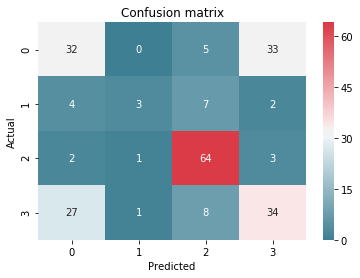

In [52]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [53]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.46      0.47        70
           1       0.60      0.19      0.29        16
           2       0.76      0.91      0.83        70
           3       0.47      0.49      0.48        70

    accuracy                           0.59       226
   macro avg       0.58      0.51      0.52       226
weighted avg       0.58      0.59      0.57       226



**Overall, the performances of this baseline model are quite poor, especially for the covid class because of the imbalance issue. We will explore data augmentation and class weigthing to improve our results.**

---

# Appendix

In [39]:
# Computing the accuracy manually to check 
(df['y_val'] == df['y_pred']).sum() / len(df)

0.5398230088495575